In [31]:
import os
import gc
import torch
import yaml
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt

In [2]:
from scripts.models.threeconv import ThreeConv
from scripts.maploader.maploader import get_data, get_minmaxnormalized_data

In [3]:
base_dir = "/gpfs02/work/akira.tokiwa/gpgpu/Github/SR-SPHERE"

config_file = f"{base_dir}/config/config_threeconv.yaml"
with open(config_file, 'r') as stream:
    config_dict = yaml.safe_load(stream)

lrmaps_dir = config_dict['data']['lrmaps_dir'] 
hrmaps_dir = config_dict['data']['hrmaps_dir']
n_maps = int(config_dict['data']['n_maps'])
nside = int(config_dict['data']['nside'])
order = int(config_dict['data']['order'])
issplit = config_dict['data']['issplit']

BATCH_SIZE = config_dict['train']['batch_size']
RATE_TRAIN = config_dict['data']['rate_train']

learning_rate = float(config_dict['train']['learning_rate'])
num_epochs = int(config_dict['train']['num_epochs'])

In [4]:
# Load data
lr = get_data(lrmaps_dir, n_maps, nside, order, issplit)
hr = get_data(hrmaps_dir, n_maps, nside, order, issplit)

lr, transforms_lr, inverse_transforms_lr, range_min_lr, range_max_lr = get_minmaxnormalized_data(lr)
print("LR data loaded. min: {}, max: {}".format(range_min_lr, range_max_lr))

hr, transforms_hr, inverse_transforms_hr, range_min_hr, range_max_hr = get_minmaxnormalized_data(hr)
print("HR data loaded. min: {}, max: {}".format(range_min_hr, range_max_hr))

LR data loaded. min: 0.0, max: 2.0128371715545654
HR data loaded. min: 0.0, max: 2.903632402420044


In [5]:
# load model
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
ckpt_path = "/gpfs02/work/akira.tokiwa/gpgpu/Github/SR-SPHERE/ckpt_logs/threeconv/HR_LR_normalized/version_2/checkpoints/Run_11-02_14-37epoch=129-val_loss=0.03.ckpt"
model = ThreeConv(in_channels=1,
                inner_channels=64,
                nside=nside,
                order=order, 
                learning_rate=learning_rate).to(device)
model.load_state_dict(torch.load(ckpt_path)["state_dict"], strict=False)
model.eval()

ThreeConv(
  (conv_in): SphericalChebConv(
    (chebconv): ChebConv()
  )
  (conv_mid): SphericalChebConv(
    (chebconv): ChebConv()
  )
  (conv_out): SphericalChebConv(
    (chebconv): ChebConv()
  )
  (ReLU): LeakyReLU(negative_slope=0.1)
  (loss_fn): MSELoss()
)

In [8]:
map_dir = "/gpfs02/work/akira.tokiwa/gpgpu/Github/SR-SPHERE/results/imgs/threeconv/"
if not os.path.exists(map_dir):
    os.makedirs(map_dir)

In [9]:
PATCH_SIZE = 12 * (config_dict['data']['order'])**2

In [17]:
with torch.no_grad():
    for i in range(int(PATCH_SIZE/BATCH_SIZE)):
        tmp_lr = lr[i*BATCH_SIZE:(i+1)*BATCH_SIZE].to(device)
        pred = model(tmp_lr)
        pred = inverse_transforms_hr(pred)
        pred = np.hstack(pred.detach().cpu().numpy()[:,:,0])
        np.save(map_dir+f"threeconv__batch{str(i).zfill(2)}.npy", pred)
        print(f"batch {i} saved.")
        del pred, tmp_lr
        torch.cuda.empty_cache()
        gc.collect()

batch 0 saved.
batch 1 saved.
batch 2 saved.
batch 3 saved.
batch 4 saved.
batch 5 saved.


In [24]:
# load all saved maps
pred = []
for i in range(int(PATCH_SIZE/BATCH_SIZE)):
    pred.append(np.load(map_dir+f"threeconv__batch{str(i).zfill(2)}.npy"))
pred = np.hstack(pred)

In [36]:
def t2hpr(x):
    x_hp = hp.pixelfunc.reorder(x, n2r=True)
    return x_hp

def log2num(x):
    return np.exp(np.log(10)*t2hpr(x)-1)

In [56]:
tmp_hr = np.hstack(inverse_transforms_hr(hr).detach().cpu().numpy()[:PATCH_SIZE,:,0])
tmp_lr = np.hstack(inverse_transforms_lr(lr).detach().cpu().numpy()[:PATCH_SIZE,:,0])

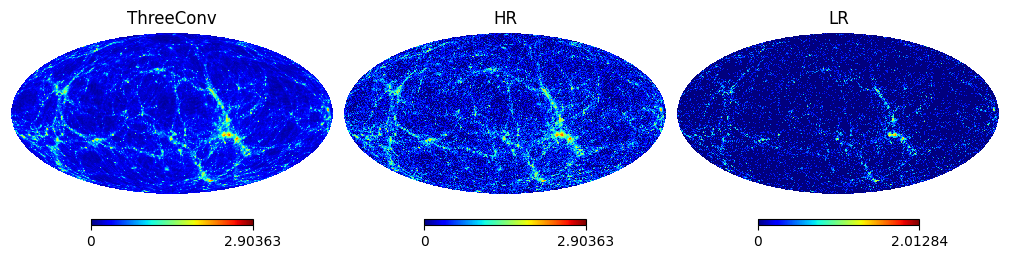

In [57]:
# plot healpix map
fig = plt.figure(figsize=(10, 5))
hp.mollview(pred, 
            title="ThreeConv", 
            cmap="jet", 
            nest=True, 
            min=range_min_hr, 
            max=range_max_hr, 
            sub=(1, 3, 1))

hp.mollview(tmp_hr,
            title="HR", 
            cmap="jet", 
            nest=True, 
            min=range_min_hr, 
            max=range_max_hr, 
            sub=(1, 3, 2))

hp.mollview(tmp_lr,
            title="LR", 
            cmap="jet", 
            nest=True, 
            min=range_min_lr, 
            max=range_max_lr, 
            sub=(1, 3, 3))

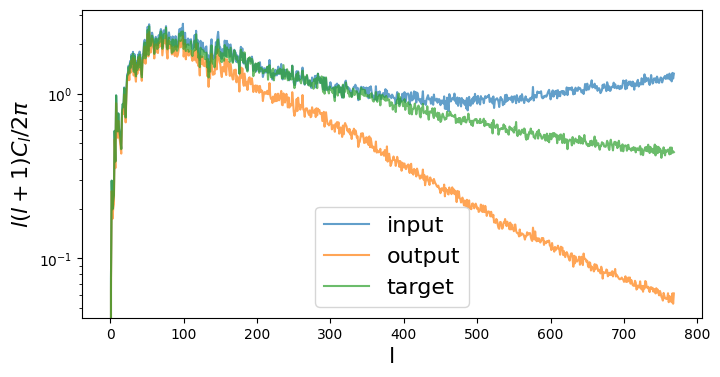

In [62]:
lmax = int(3/2 * nside)
input_cl =hp.sphtfunc.anafast(log2num(tmp_lr), lmax=lmax) * 64
target_cl =hp.sphtfunc.anafast(log2num(tmp_hr), lmax=lmax)
pred_cl =hp.sphtfunc.anafast(log2num(pred), lmax=lmax)
cls = [input_cl, pred_cl, target_cl]

fig, ax = plt.subplots(1,1, figsize=(8,4))
labels = ["input", "output", "target"]

ell = np.arange(len(cls[0]))
for cl, label in zip(cls, labels):
    ax.plot(ell*(ell+1)*cl/(2*np.pi), label=label, alpha=0.7)
ax.set_xlabel("l", fontsize=16)
ax.set_ylabel(r"$l(l+1)C_{l}/2\pi\;\; $", fontsize=16)
ax.set_yscale("log")
ax.legend(fontsize=16)

plt.show()